In [99]:
%matplotlib inline
import skbio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from math import ceil
import seaborn
seaborn.set_style('white')



Using the full American Gut mapping file, we reduced it to only samples that were fecal. 
The mapping file was then filtered to remove samples which did not have sufficient data 
(after bloom removal). Following this, host subject IDs representing only a single sample 
were removed. The time deltas were then generated by iterating over each host subject ID, 
and computing the time difference in days between all samples associated with that host 
subject ID.

In [100]:
dm = skbio.DistanceMatrix.read('ag-cleaned-multiple-timepoints_even1250_unweighted.txt')
w_dm = skbio.DistanceMatrix.read('ag-cleaned-multiple-timepoints_even1250_weighted.txt')
deltas = pd.read_csv('ag-cleaned-multiple-timepoints-deltas.txt', sep='\t', dtype=str)


In [101]:
deltas['DeltaInDays'] = pd.to_numeric(deltas['DeltaInDays'])
absdeltas = deltas
absdeltas['DeltaInDays'] = deltas['DeltaInDays'].abs()


In [102]:
distance = []
for dl in range(len(absdeltas)):
    distance.append(dm[absdeltas['SampleID-A'][dl], absdeltas['SampleID-B'][dl]])

absdeltas['Distance'] = distance


In [103]:
def ret_del_months(row):
    if ceil(row.DeltaInDays/30) > 12:
        return 13
    elif ceil(row.DeltaInDays/30) == 0:
        return 1
    else:
        return ceil(row.DeltaInDays/30)

absdeltas['DeltaInMonths']= absdeltas.apply(ret_del_months, axis=1, reduce=False)


### Here I filter out unique host subjects from each month in the absdeltas dataframe 

In [104]:

blackset = set([])
uni_sub_del = pd.DataFrame()
for index, row in absdeltas.iterrows():
    a = (row.HOST_SUBJECT_ID, row.DeltaInMonths)
    if a not in blackset:
        uni_sub_del = uni_sub_del.append(row, ignore_index = True)
        blackset.add(a)
        
    

### Here I filter out all within sample distances from the weighted and unweighted distance matrices,
### leaving only between sample distances

In [105]:
between_dm = dm
for ser in range(len(absdeltas)):
    ind1 = absdeltas['SampleID-A'][ser]
    ind2 = absdeltas['SampleID-B'][ser]
    bind1 = between_dm.index(ind1)
    bind2 = between_dm.index(ind2)
    between_dm[bind1][bind2] = 0
    between_dm[bind2][bind1] = 0
    
w_between_dm = w_dm
for ser in range(len(absdeltas)):
    ind1 = absdeltas['SampleID-A'][ser]
    ind2 = absdeltas['SampleID-B'][ser]
    bind1 = w_between_dm.index(ind1)
    bind2 = w_between_dm.index(ind2)
    w_between_dm[bind1][bind2] = 0
    w_between_dm[bind2][bind1] = 0
    
w_between_cform = w_between_dm.condensed_form()
w_zero_indexes = []
for i in range(len(w_between_cform)):
    if w_between_cform[i] == 0:
        w_zero_indexes.append(i)

w_between_arr = np.delete(w_between_cform, w_zero_indexes)


In [106]:
between_cform = between_dm.condensed_form()


In [107]:
zero_indexes = []
for i in range(len(between_cform)):
    if between_cform[i] == 0:
        zero_indexes.append(i)
        

In [108]:
between_arr = np.delete(between_cform, zero_indexes)


In [109]:
w_dm = skbio.DistanceMatrix.read('ag-cleaned-multiple-timepoints_even1250_weighted.txt')


In [110]:
w_distance = []
for dl in range(len(absdeltas)):
    w_distance.append(w_dm[absdeltas['SampleID-A'][dl], absdeltas['SampleID-B'][dl]])

absdeltas['Weighted Distance'] = w_distance


In [111]:
w_distance = []
for dl in range(len(uni_sub_del)):
    w_distance.append(w_dm[uni_sub_del['SampleID-A'][dl], uni_sub_del['SampleID-B'][dl]])

uni_sub_del['Weighted Distance'] = w_distance


In [112]:
#create the column for unweighted between sample distances, labeled BSD
bet_delmonths = []
w_bet_delmonths = []
for i in range(len(between_arr)):
    bet_delmonths.append(14)
for i in range(len(w_between_arr)):
    w_bet_delmonths.append(14)
    

In [113]:
bet_cols = ['Distance']
between_df = pd.DataFrame(data=between_arr, columns=bet_cols)


In [114]:
between_df["DeltaInMonths"] = bet_delmonths


In [115]:
w_bet_cols = ['Weighted Distance']

w_between_df = pd.DataFrame(data=w_between_arr, columns=w_bet_cols)
w_between_df["DeltaInMonths"] = w_bet_delmonths
tot_between_df = pd.concat([between_df, w_between_df], ignore_index=True)


In [116]:
with_betweens_absdeltas = absdeltas.append(tot_between_df, ignore_index=True)


# RESULTS 
Here are the boxplots with the unweighted distances including the between sample distances as month 14, and below those are the boxplots of the weighted samples. As expected, the median for the between sample distances in notably higher than within sample distances. 

## Unweighted Distances for all within sample distances

In [117]:
#BSD denotes between sample distances
with_betweens_absdeltas['DeltaInMonths'] = pd.to_numeric(with_betweens_absdeltas['DeltaInMonths'], downcast='integer')
with_betweens_absdeltas.loc[with_betweens_absdeltas.DeltaInMonths == 14, 'DeltaInMonths'] = 'BSD'
with_betweens_absdeltas.loc[with_betweens_absdeltas.DeltaInMonths == 13, 'DeltaInMonths'] = '>12'


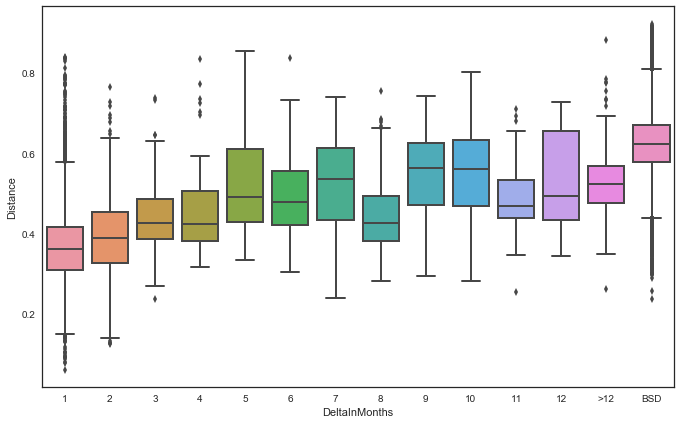

In [118]:
boxorder = [1,2,3,4,5,6,7,8,9,10,11,12,'>12','BSD']
fig = plt.figure(figsize=((7*1.618033),7))
ax = fig.add_subplot(111)
seaborn.boxplot(x="DeltaInMonths", y="Distance", data=with_betweens_absdeltas, order=boxorder, ax=ax)


## Unweighted Distances for only unique subject distances in each month

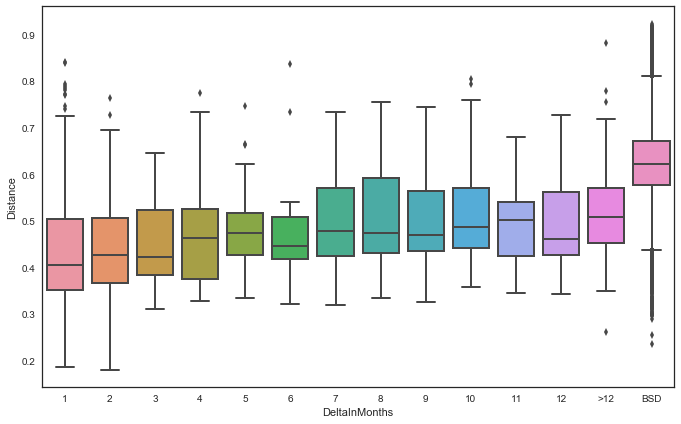

In [119]:
#BSD denotes between sample distances
with_betweens_unisubs = uni_sub_del.append(tot_between_df, ignore_index=True)
boxorder = [1,2,3,4,5,6,7,8,9,10,11,12,'>12','BSD']
with_betweens_unisubs['DeltaInMonths'] = pd.to_numeric(with_betweens_unisubs['DeltaInMonths'], downcast='integer')
with_betweens_unisubs.loc[with_betweens_unisubs.DeltaInMonths == 14, 'DeltaInMonths'] = 'BSD'
with_betweens_unisubs.loc[with_betweens_unisubs.DeltaInMonths == 13, 'DeltaInMonths'] = '>12'
fig = plt.figure(figsize=((7*1.618033),7))
ax = fig.add_subplot(111)
seaborn.boxplot(x="DeltaInMonths", y="Distance", data=with_betweens_unisubs, order=boxorder, ax=ax)
plt.savefig('unweighted_unique.pdf', format='pdf')



## Weighted Distances for all within sample distances

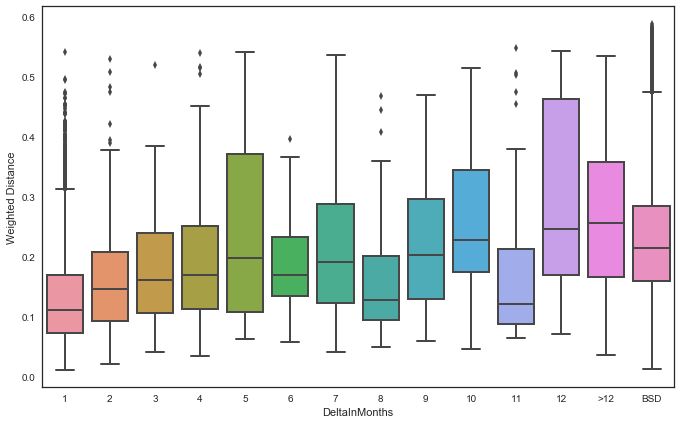

In [120]:
fig = plt.figure(figsize=((7*1.618033),7))
ax = fig.add_subplot(111)
seaborn.boxplot(x="DeltaInMonths", y="Weighted Distance", data=with_betweens_absdeltas, order=boxorder, ax=ax)



## Weighted Distances for only unique subject distances in each month

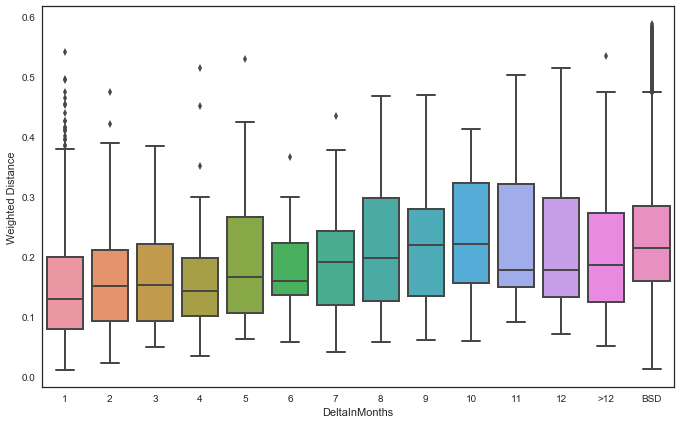

In [121]:
fig = plt.figure(figsize=((7*1.618033),7))
ax = fig.add_subplot(111)
seaborn.boxplot(x="DeltaInMonths", y="Weighted Distance", data=with_betweens_unisubs, order=boxorder, ax=ax)
plt.savefig('weighted_unique.pdf', format='pdf')


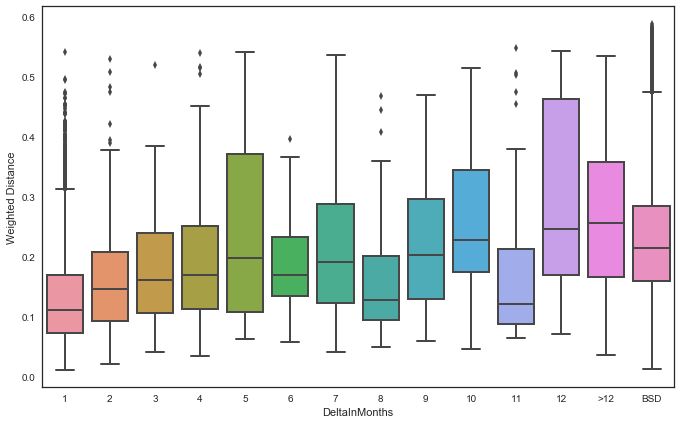

In [122]:
fig = plt.figure(figsize=((7*1.618033),7))
ax = fig.add_subplot(111)
seaborn.boxplot(x="DeltaInMonths", y="Weighted Distance", data=with_betweens_absdeltas, order=boxorder, ax=ax)


In [123]:
counts = with_betweens_unisubs['DeltaInMonths'].value_counts()


In [124]:
del_in_month_counts = []
for i in range(counts.sum() - counts['BSD']):
    j = with_betweens_unisubs['DeltaInMonths'][i]
    dimc = str(with_betweens_unisubs['DeltaInMonths'][i]) + '(' + str(counts[j]) + ')'
    del_in_month_counts.append(dimc)
    

In [125]:
bsds = with_betweens_unisubs['DeltaInMonths'][(counts.sum()-counts['BSD']):counts.sum()]


In [126]:
#del_in_month_counts.append(bsds.values)


In [127]:
del_in_month_countsnp = np.array(del_in_month_counts)


In [128]:
trimonths = []
for i in range(counts.sum() - counts['BSD']):
    if with_betweens_unisubs['DeltaInMonths'][i] in range(1, 4):
        trimonths.append('1-3')
    elif with_betweens_unisubs['DeltaInMonths'][i] in range(4, 7):
        trimonths.append('4-6')
    elif with_betweens_unisubs['DeltaInMonths'][i] in range(7, 10):
        trimonths.append('7-9')
    elif with_betweens_unisubs['DeltaInMonths'][i] in range(10, 13):
        trimonths.append('10-12')
    elif with_betweens_unisubs['DeltaInMonths'][i] == '>12':
        trimonths.append('>12')

for i in range(counts['BSD']):
    trimonths.append('BSD')
    

In [129]:
with_betweens_unisubs['DeltaInMonths(by three)'] = trimonths


# Unique subject unweighted within sample distances by 3 months 

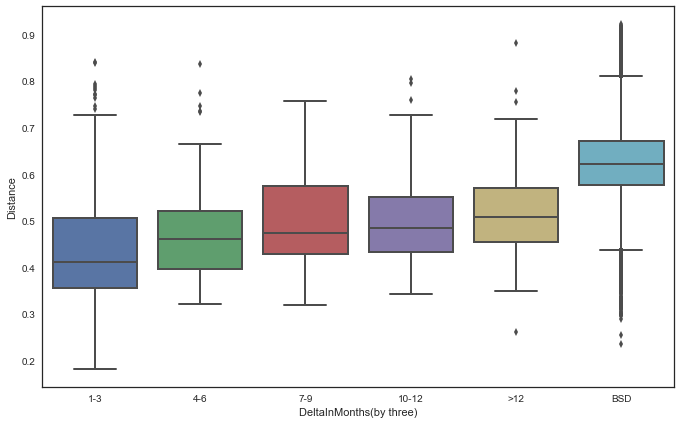

In [130]:
boxorder=['1-3', '4-6', '7-9', '10-12', '>12', 'BSD']
fig = plt.figure(figsize=((7*1.618033),7))
ax = fig.add_subplot(111)
seaborn.boxplot(x='DeltaInMonths(by three)', y='Distance', data=with_betweens_unisubs, order=boxorder, width=.8, ax=ax)
plt.savefig('unique_by_3month.pdf', format='pdf')


# Unique subject plots with sample counts

In [131]:
# This figure has been generated and saved, if any alterations need to be made, I should
# refactor this function. This cell takes about 6 or 7 minutes to compute
unicounts = with_betweens_unisubs['DeltaInMonths'].value_counts()
def ret_samp_counts(row):
    if row.DeltaInMonths == 'BSD':
        return 'BSD'
    else:
        delmon = str(row.DeltaInMonths)
        count = str(unicounts[row.DeltaInMonths])
        del_count = delmon + '(' + count + ')'
        return del_count

with_betweens_unisubs['DeltaInMonths(#samples)'] = with_betweens_unisubs.apply(ret_samp_counts, axis=1, reduce=False)


In [132]:
with_betweens_unisubs['Months Between Samples (#samples)'] = with_betweens_unisubs['DeltaInMonths(#samples)']
with_betweens_unisubs['Unweighted Unifrac Distance'] = with_betweens_unisubs['Distance']


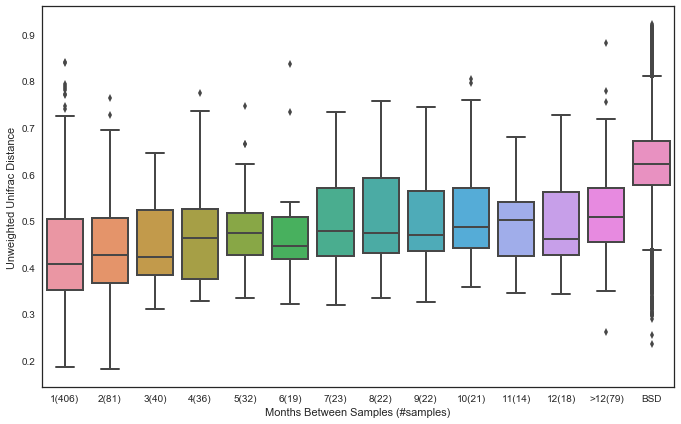

In [133]:
boxorder=['1(406)', '2(81)', '3(40)','4(36)', '5(32)', '6(19)', '7(23)', '8(22)', '9(22)', '10(21)', '11(14)', '12(18)', 
          '>12(79)', 'BSD']
fig = plt.figure(figsize=((7*1.618033),7))
ax = fig.add_subplot(111)
seaborn.boxplot(x='Months Between Samples (#samples)', y='Unweighted Unifrac Distance', 
                data=with_betweens_unisubs, order=boxorder, width=.8, ax=ax)
plt.savefig('unique_with_count.pdf', format='pdf')

